In [1]:
#normalize=numpy.linalg.inv(numpy.diag([60,1e3,2e3,6e3,2e3,2e3,2e3,1,1,3e3,3e3,1500]))
import sys,pandas
sys.path.append('/home/heyangle/Desktop/ScanCraft/ScanCraft')
from command.scan.scan import scan

mold=scan(method='random')
mold.AddScalar('tanB','MINPAR',3,1.,60.)
mold.AddScalar('Atop','EXTPAR'   ,11  ,  -6e3    ,6e3)
mold.AddFollower('Abottom','EXTPAR'   ,12,'Atop')
mold.AddScalar('Lambda','EXTPAR'  ,61  ,1e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('Kappa','EXTPAR'   ,62 ,1.e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('A_Lambda','EXTPAR' ,63,-3.e3,3.e3)
mold.AddScalar('A_kappa','EXTPAR' ,64,-3.e3,3.e3)
mold.AddScalar('mu_eff','EXTPAR'  ,65,100.,1500.)

In [4]:
acc_DF=pandas.read_csv('Pylon/accepted_all.csv',header=[0,1,2,3],index_col=0)
mh_DF=pandas.read_csv('Pylon/Higgs_mass.csv',header=[0,1,2,3],index_col=0)

In [5]:
from command.pytorch.normalize import GetRanges
data_range=GetRanges(mold.free_parameter_list)
acc_norm=(acc_DF.values[:,:7]-(data_range[0]+data_range[1])/2.)/(data_range[1]-data_range[0])*2

In [33]:
import numpy
mh_log=numpy.log10(mh_DF.values)

In [34]:
mh_log

array([[ 1.99445891,  3.84828885,  4.22229743],
       [ 2.11152964,  4.485591  ,  4.55334264],
       [ 1.73938592,  4.51086802,  4.97974624],
       ..., 
       [ 2.09322562,  4.65758514,  4.8814204 ],
       [ 2.23957546,  4.49416182,  4.61142361],
       [ 2.00067699,  4.26110356,  4.76809292]])

In [3]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

In [35]:
inp=Variable(torch.FloatTensor(acc_norm).cuda())
out=Variable(torch.FloatTensor(mh_log).cuda())

In [46]:
out.shape

torch.Size([11243, 3])

In [65]:
class nn_mh(nn.Module):
    def __init__(self,D_in,d1,d2):
        super(nn_mh,self).__init__()
        self.l1=torch.nn.Linear(D_in, d1)
        self.l2=torch.nn.Linear(d1,d2)
        self.l3=torch.nn.Linear(d2,3)
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=F.leaky_relu(x)
        x=self.l3(x)
        return x

In [66]:
net=nn_mh(7,500,300).cuda()
MSE=nn.MSELoss()


In [70]:
opt=torch.optim.Adam(net.parameters(),lr=0.0001)
for i in range(1000):
    pre=net(inp)
    loss=MSE(pre,out)
    if i%100==0:
        print(i,loss.data[0])
    opt.zero_grad()
    loss.backward()
    opt.step()

0 0.0038297511637210846
100 0.0036436959635466337
200 0.003596972906962037
300 0.0035412146244198084
400 0.003479535458609462
500 0.0034102508798241615
600 0.0033442822750657797
700 0.0032752910628914833
800 0.0032095536589622498
900 0.003148209536448121


In [87]:
pre_array=pre.cpu().data.numpy()

In [88]:
mh_log

array([[ 1.99445891,  3.84828885,  4.22229743],
       [ 2.11152964,  4.485591  ,  4.55334264],
       [ 1.73938592,  4.51086802,  4.97974624],
       ..., 
       [ 2.09322562,  4.65758514,  4.8814204 ],
       [ 2.23957546,  4.49416182,  4.61142361],
       [ 2.00067699,  4.26110356,  4.76809292]])

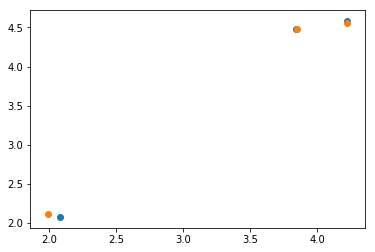

In [89]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(pre_array[0],pre_array[1])
plt.scatter(mh_log[0],mh_log[1])
plt.show()